In [174]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

def root_mean_squared_error(actual, predicted):
    """
    RMSE (Root Mean Squared Error) 계산

    Args:
        actual (numpy array 또는 list): 실제 값의 배열
        predicted (numpy array 또는 list): 예측 값의 배열

    Returns:
        float: RMSE
    """
    return np.sqrt(mean_squared_error(actual, predicted))

def mean_absolute_deviation(actual, predicted):
    """
    MAD (Mean Absolute Deviation) 계산

    Args:
        actual (numpy array 또는 list): 실제 값의 배열
        predicted (numpy array 또는 list): 예측 값의 배열

    Returns:
        float: MAD
    """
    return np.mean(np.abs(actual - predicted))

def mean_absolute_percentage_error(actual, predicted):
    """
    MAPE (Mean Absolute Percentage Error) 계산

    Args:
        actual (numpy array 또는 list): 실제 값의 배열
        predicted (numpy array 또는 list): 예측 값의 배열

    Returns:
        float: MAPE
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

def mean_absolute_scaled_error(actual, predicted):
    """
    MASE (Mean Absolute Scaled Error) 계산

    Args:
        actual (numpy array 또는 list): 실제 값의 배열
        predicted (numpy array 또는 list): 예측 값의 배열

    Returns:
        float: MASE
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    numerator = abs(actual - predicted).sum(1)
    denominator = abs(actual[:, :-1] - actual[:, 1:]).sum(1) / (actual.shape[1] - 1)
        
    return np.mean(numerator/denominator)
    

In [175]:
urban_core = pd.read_csv('data/urban-core.csv', header=None)
urban_mix = pd.read_csv('data/urban-mix.csv', header=None)

urban_core_speed = urban_core.drop(urban_core.columns[:7], axis=1)
urban_mix_speed = urban_mix.drop(urban_mix.columns[:7], axis=1)

n = 12 # 직전 train data 개수 (1시간 = 12개)
m = 12*24*7  # 테스트 데이터 개수 (7일 = 12*24*7개)

# Urban-Core

In [190]:
X_train = []  # 훈련용 입력 데이터
y_train = []  # 훈련용 정답 데이터

for i in tqdm(range(urban_core_speed.shape[0])):
    for j in range(urban_core_speed.shape[1] - m):
        X_train.append(urban_core_speed.iloc[i, j:j+n].values)  # 현재 행에서 1부터 n+1까지의 열 값을 X로 사용
        y_train.append(urban_core_speed.iloc[i, j+n+1])  # n+1 열의 값을 y로 사용
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [191]:
# OLS 모델 생성 및 훈련
model = sm.OLS(y_train, X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          1.024e+07
Date:                Sun, 17 Sep 2023   Prob (F-statistic):                        0.00
Time:                        17:27:15   Log-Likelihood:                     -5.5376e+06
No. Observations:             2013696   AIC:                                  1.108e+07
Df Residuals:                 2013684   BIC:                                  1.108e+07
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0227      0.001     31.016      0.000       0.021       0.024
x2             0.0210      0.001     27.466      0.000       0.019       0.022
x3             0.0162      0.001     20.658      0.000       0.015       0.018
x4             0.0129      0.001     16.260      0.000       0.011       0.014
x5             0.0102      0.001     12.786      0.000       0.009       0.012
x6             0.0255      0.001     31.957      0.000       0.024       0.027
x7             0.0392      0.001     49.040      0.000       0.038       0.041
x8             0.0428      0.001     53.599      0.000       0.041       0.044
x9             0.0706      0.001     88.848      0.000       0.069       0.072
x10            0.1685      0.001    214.758      0.000       0.167       0.170
x11            0.2407      0.001    314.994      0.000       0.239       0.242
x12            0.3266      0.001    445.164      0.000       0.325       0.328
==============================================================================
Omnibus:                   414187.030   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7772172.742
Skew:                           0.494   Prob(JB):                         0.00
Kurtosis:                      12.574   Cond. No.                         33.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [192]:
for j in tqdm(range(urban_core_speed.shape[1] - n - m - 1, urban_core_speed.shape[1] - n - 1)):
    X_test = []   # 테스트용 입력 데이터
    for i in range(urban_core_speed.shape[0]):
        X_test.append(urban_core_speed.iloc[i, j:j+n].values)  # 현재 행에서 1부터 n+1까지의 열 값을 X로 사용

    forecast = results.predict(X_test)
    urban_core_speed.iloc[:, j+n+1] = list(forecast)


100%|██████████| 2016/2016 [00:35<00:00, 56.36it/s]


In [193]:
y_test = np.array(urban_core.iloc[:, urban_core.shape[1] - m:])
y_pred = np.array(urban_core_speed.iloc[:, urban_core_speed.shape[1] - m:])

# 각각의 지표 계산
rmse_result = root_mean_squared_error(y_test, y_pred)
mad_result = mean_absolute_deviation(y_test, y_pred)
mape_result = mean_absolute_percentage_error(y_test, y_pred)
mase_result = mean_absolute_scaled_error(y_test, y_pred)

print(f"RMSE: {rmse_result:.2f}")
print(f"MAD: {mad_result:.2f}")
print(f"MAPE: {mape_result:.2f}%")
print(f"MASE: {mase_result:.2f}")

RMSE: 16.32
MAD: 13.28
MAPE: 46.91%
MASE: 10064.31


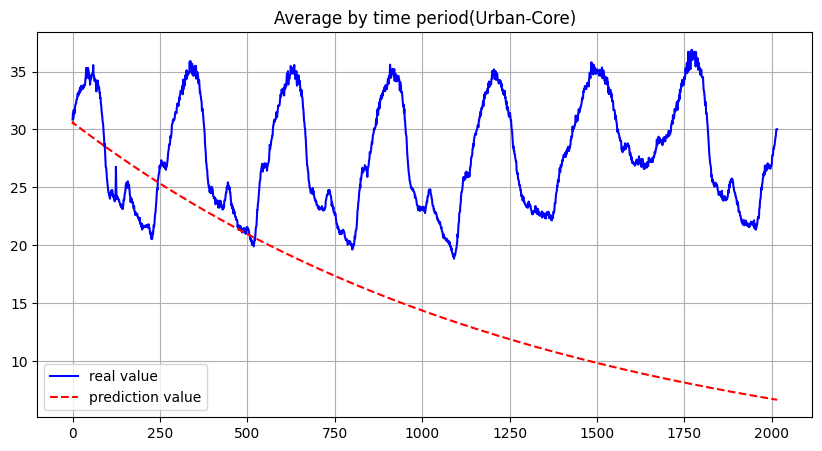

In [194]:
# 각 행에 대한 평균 계산
y_test_mean = np.mean(y_test, axis=0)
y_pred_mean = np.mean(y_pred, axis=0)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(y_test_mean, label='real value',  linestyle='-', color='b')
plt.plot(y_pred_mean, label='prediction value', linestyle='--', color='r')
plt.title('Average by time period(Urban-Core)')
plt.legend()
plt.grid(True)
plt.show()

# Urban-Mix

In [183]:
X_train = []  # 훈련용 입력 데이터
y_train = []  # 훈련용 정답 데이터

for i in tqdm(range(urban_mix_speed.shape[0])):
    for j in range(urban_mix_speed.shape[1] - m):
        X_train.append(urban_mix_speed.iloc[i, j:j+n].values)  # 현재 행에서 1부터 n+1까지의 열 값을 X로 사용
        y_train.append(urban_mix_speed.iloc[i, j+n+1])  # n+1 열의 값을 y로 사용
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1007/1007 [08:24<00:00,  2.00it/s]


In [184]:
# OLS 모델 생성 및 훈련
# X = sm.add_constant(X)  # 상수 항 추가
model = sm.OLS(y_train, X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          3.541e+07
Date:                Sun, 17 Sep 2023   Prob (F-statistic):                        0.00
Time:                        17:14:05   Log-Likelihood:                     -1.9265e+07
No. Observations:             6670368   AIC:                                  3.853e+07
Df Residuals:                 6670356   BIC:                                  3.853e+07
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0333      0.000     78.622      0.000       0.032       0.034
x2             0.0255      0.000     55.045      0.000       0.025       0.026
x3             0.0138      0.000     28.925      0.000       0.013       0.015
x4             0.0074      0.000     15.365      0.000       0.006       0.008
x5             0.0063      0.000     13.143      0.000       0.005       0.007
x6             0.0123      0.000     25.555      0.000       0.011       0.013
x7             0.0154      0.000     32.013      0.000       0.014       0.016
x8             0.0070      0.000     14.477      0.000       0.006       0.008
x9             0.0310      0.000     64.659      0.000       0.030       0.032
x10            0.1295      0.000    271.888      0.000       0.129       0.130
x11            0.2550      0.000    550.913      0.000       0.254       0.256
x12            0.4600      0.000   1087.119      0.000       0.459       0.461
==============================================================================
Omnibus:                  1641105.096   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         67071480.651
Skew:                           0.435   Prob(JB):                         0.00
Kurtosis:                      18.510   Cond. No.                         39.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
for j in tqdm(range(urban_mix_speed.shape[1] - n - m - 1, urban_mix_speed.shape[1] - n - 1)):
    X_test = []   # 테스트용 입력 데이터
    for i in range(urban_mix_speed.shape[0]):
        X_test.append(urban_mix_speed.iloc[i, j:j+n].values)  # 현재 행에서 1부터 n+1까지의 열 값을 X로 사용

    forecast = results.predict(X_test)
    urban_mix_speed.iloc[:, j+n+1] = list(forecast)


100%|██████████| 2016/2016 [03:33<00:00,  9.42it/s]


In [188]:
y_test = np.array(urban_mix.iloc[:, urban_mix.shape[1] - m:])
y_pred = np.array(urban_mix_speed.iloc[:, urban_mix_speed.shape[1] - m:])

# 각각의 지표 계산
rmse_result = root_mean_squared_error(y_test, y_pred)
mad_result = mean_absolute_deviation(y_test, y_pred)
mape_result = mean_absolute_percentage_error(y_test, y_pred)
mase_result = mean_absolute_scaled_error(y_test, y_pred)

print(f"RMSE: {rmse_result:.2f}")
print(f"MAD: {mad_result:.2f}")
print(f"MAPE: {mape_result:.2f}%")
print(f"MASE: {mase_result:.2f}")

RMSE: 22.40
MAD: 18.03
MAPE: 57.79%
MASE: 13641.80


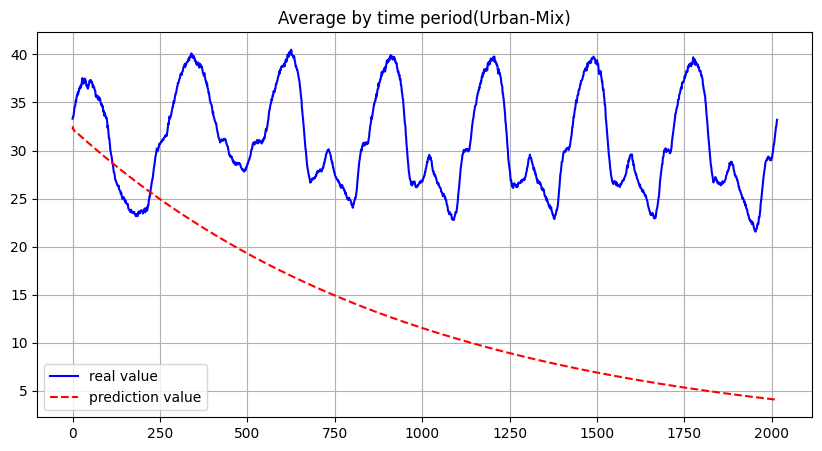

In [189]:
# 각 행에 대한 평균 계산
y_test_mean = np.mean(y_test, axis=0)
y_pred_mean = np.mean(y_pred, axis=0)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(y_test_mean, label='real value',  linestyle='-', color='b')
plt.plot(y_pred_mean, label='prediction value', linestyle='--', color='r')
plt.title('Average by time period(Urban-Mix)')
plt.legend()
plt.grid(True)
plt.show()